In [1]:
import sys
sys.path.append("..")
%load_ext line_profiler

import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
from utils.download_mnist import mnist_dataloader_test
from assembler import get_config, get_config_ebm, make_energy_model
from utils.config import show 

path = !cd .. && pwd
path = path[0]

def plotable(img):
    return rearrange(img, "b c h w -> (b c h) w ").cpu().detach().numpy()

def get_model_config(model_name):
    dataset, model, sampling, task = model_name.split("/")
    name = f"{sampling}/{task}"
    config = get_config(get_config_ebm, dataset, model, name, path=path)
    return config

def experiment(config, x):
    ebm = make_energy_model(config, path=path)
    
    # The math
    x_tilde = ebm.operator(x)
    x_hat = ebm(x_tilde)
    
    # The result
    fig, axs = plt.subplots(nrows = 1, ncols = 2)
    axs[0].set_title("original")
    axs[0].imshow(plotable(x))
    axs[1].set_title("estimation")
    axs[1].imshow(plotable(x_hat))
    plt.show()

In [2]:
model_name = "mnist/vae/langevin/inpainting"
config = get_model_config(model_name)
dm = mnist_dataloader_test(config, path=path)
gen = iter(dm)

/home/mingliang/anaconda3/envs/torch3090/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
show(config)

operator_params
    operator: CenterOcclude
    size: 13
estimator_params
    estimator: langevin
    burn_in: 0
    n_samples: 15
    step_size: 0.01
    mode: avg
    initalisation: posterior
    potential: mse
base_model_params
    model_name: mnist/vae/vanilla


In [4]:
x, y = next(gen)

In [5]:
config['estimator_params']['potential'] = "discriminator_weighted"
config['estimator_params']['lambda'] = 1
config['estimator_params']['discriminator_base_model'] = "mnist/gan/dcgan"

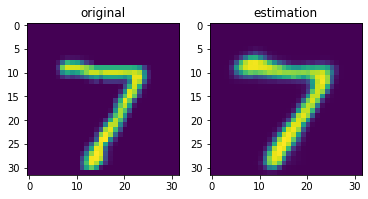

In [6]:
experiment(config, x)

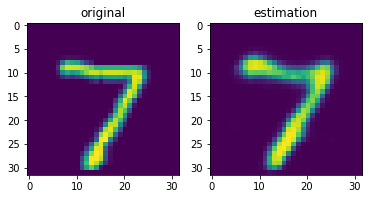

In [10]:
%lprun -f experiment experiment(config, x)

In [15]:
ebm = make_energy_model(config, path=path)
ebm = ebm.to("cuda")
ebm.kwargs["discriminator"].to("cuda")

DCGANDiscriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): Identity()
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slo

In [16]:
x = x.to("cuda")
x_tilde = ebm.operator(x)
x_hat = ebm(x_tilde)

In [17]:
%lprun -f ebm ebm(x_tilde)